* Variable	Definition	Key
* survival	Survival	0 = No, 1 = Yes
* pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    * 1st = Upper
    * 2nd = Middle
    * 3rd = Lower
* sex	Sex	
* Age	Age in years	
* sibsp	# of siblings(兄弟) / spouses（配偶者） aboard the Titanic	
* parch	# of parents（親） / children（子供） aboard the Titanic	
* ticket	Ticket number	
* fare	Passenger fare	
* cabin	Cabin number	
* embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [128]:
#テスト
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import os

In [129]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

### データの確認

In [130]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [131]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [132]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* survived mean p = 0.38
* age mean と medianが近い→正規分布？
* fare mean = 32 ,median = 14,4　数値に開きがある→分布も偏りがあるのではないか？

In [133]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [134]:
train.drop(["PassengerId", "Name", "Ticket"], axis=1, inplace=True)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [135]:
test.drop(["PassengerId", "Name", "Ticket"], axis=1, inplace=True)
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,34.5,0,0,7.8292,NaN,Q
1,3,female,47.0,1,0,7.0000,NaN,S
2,2,male,62.0,0,0,9.6875,NaN,Q
3,3,male,27.0,0,0,8.6625,NaN,S
4,3,female,22.0,1,1,12.2875,NaN,S


#### ID:2

In [136]:
from sklearn.preprocessing import LabelEncoder
  
# 性別の数値化
sex_le = LabelEncoder()
train['Sex'] = sex_le.fit_transform(train['Sex'])
test['Sex'] = sex_le.fit_transform(test['Sex'])
 
# 出港地の数値化
town_le = LabelEncoder()
train['Embarked'] = town_le.fit_transform(train['Embarked'])
test['Embarked'] = town_le.fit_transform(test['Embarked'])

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,NaN,2
1,1,1,0,38.0,1,0,71.2833,C85,0
2,1,3,0,26.0,0,0,7.9250,NaN,2
3,1,1,0,35.0,1,0,53.1000,C123,2
4,0,3,1,35.0,0,0,8.0500,NaN,2


### EDA(探索的データ分析)

#### ID:1

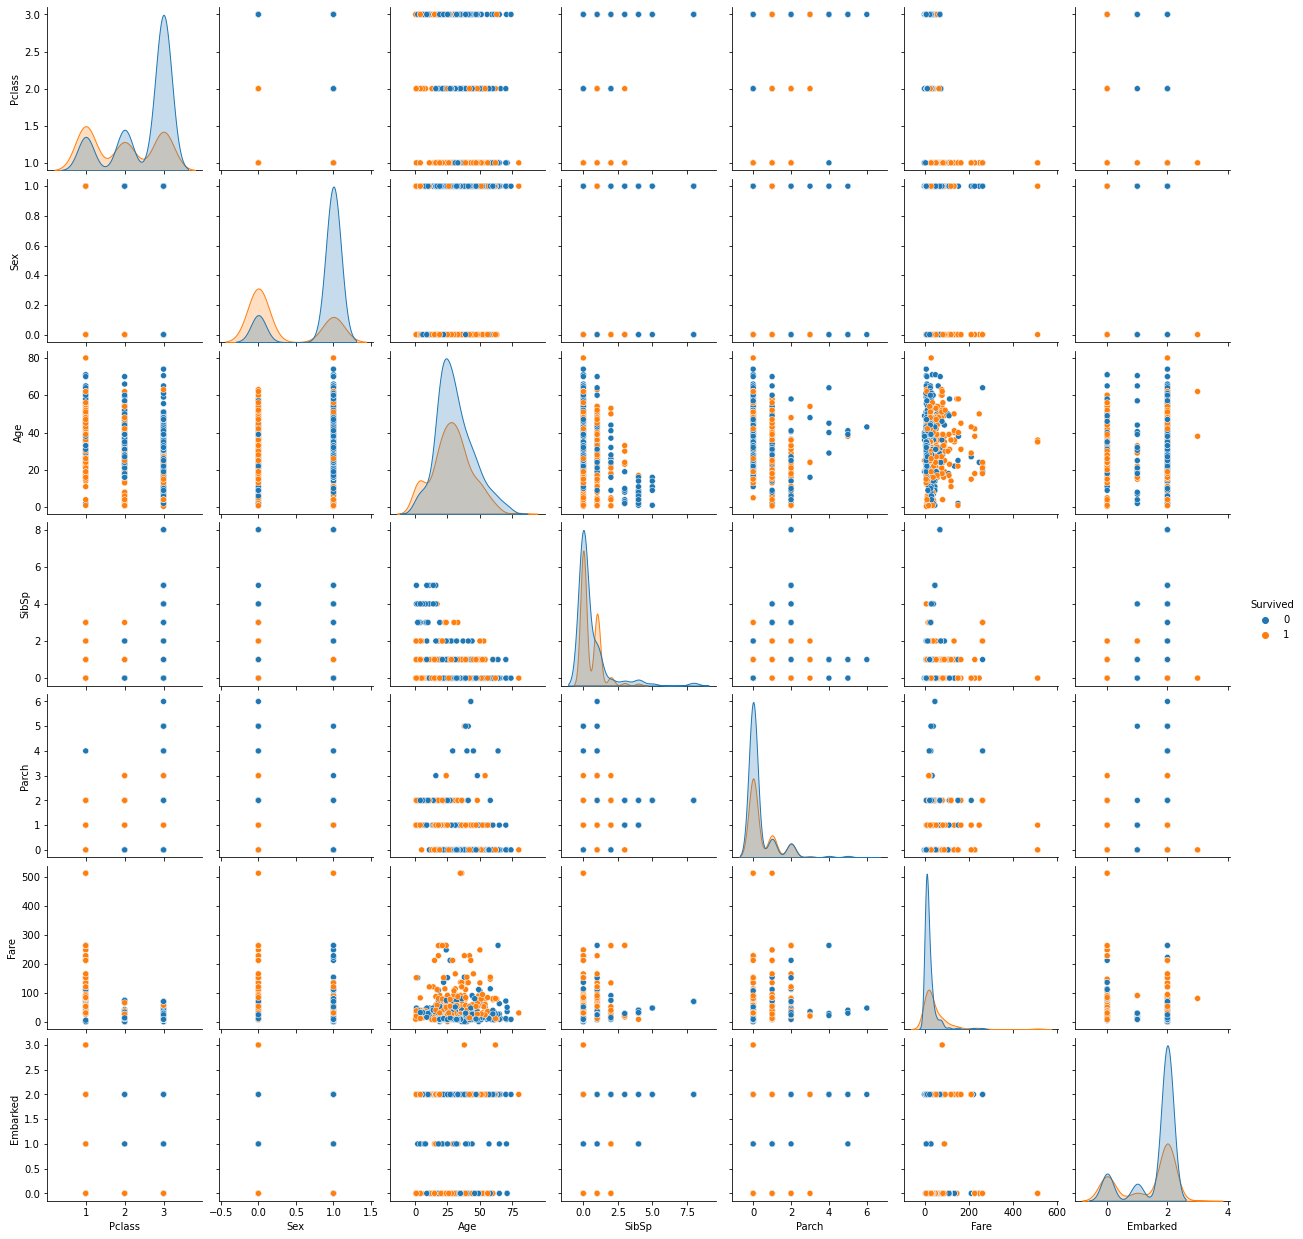

In [137]:
sns.pairplot(train, hue= 'Survived')
plt.show()

* ageは正規分布に従う
* surviede=1に小さな山がある→年少者を生かした可能性
* sibsp,parch,Fareは歪度がマイナス、左によっている。
* →Fareは対数変換して正規分布に近づけて使用していいかも
*　女性の方が生き残りやすいが、料金が低いと死亡率が上がる

In [138]:
train.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.338481,-0.543351,-0.077221,-0.035322,0.081629,0.257307,-0.163517
Pclass,-0.338481,1.000000,0.131900,-0.369226,0.083081,0.018443,-0.549500,0.157112
Sex,-0.543351,0.131900,1.000000,0.093254,-0.114631,-0.245489,-0.182333,0.104057
Age,-0.077221,-0.369226,0.093254,1.000000,-0.308247,-0.189119,0.096067,-0.025252
SibSp,-0.035322,0.083081,-0.114631,-0.308247,1.000000,0.414838,0.159651,0.066654
Parch,0.081629,0.018443,-0.245489,-0.189119,0.414838,1.000000,0.216225,0.038322
Fare,0.257307,-0.549500,-0.182333,0.096067,0.159651,0.216225,1.000000,-0.221226
Embarked,-0.163517,0.157112,0.104057,-0.025252,0.066654,0.038322,-0.221226,1.000000


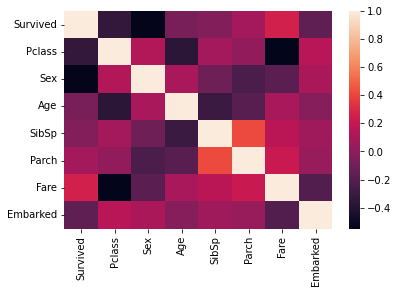

In [139]:
sns.heatmap(train.corr())
plt.show()

In [142]:
np.log(train['Fare'])

/Users/terasawayasuto/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0      1.981001
1      4.266662
2      2.070022
3      3.972177
4      2.085672
         ...   
886    2.564949
887    3.401197
888    3.154870
889    3.401197
890    2.047693
Name: Fare, Length: 891, dtype: float64

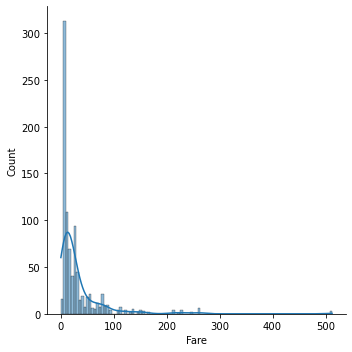

In [140]:
sns.displot(train['Fare'], kde=True)
plt.show()

#### ID:4

In [143]:
train['Fare'] = np.log(train['Fare'])
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,1.981001,NaN,2
1,1,1,0,38.0,1,0,4.266662,C85,0
2,1,3,0,26.0,0,0,2.070022,NaN,2
3,1,1,0,35.0,1,0,3.972177,C123,2
4,0,3,1,35.0,0,0,2.085672,NaN,2


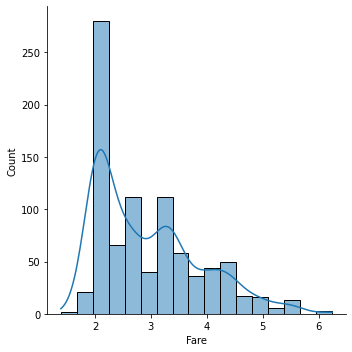

In [144]:
sns.displot(train['Fare'], kde=True)
plt.show()

In [145]:
label = train["Survived"]
train.drop(["Survived"], axis=1, inplace=True)

In [146]:
print(train.shape, test.shape)
train.dtypes

(891, 8) (418, 8)


Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked      int64
dtype: object

In [147]:
#category変数のdtypeをcategotyに変換
cat_feat = ["Pclass", "Sex", "Cabin", "Embarked"]
for i in cat_feat :
    train[i] = train[i].astype("category")
    test[i] = test[i].astype("category")

In [148]:
train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,1.981001,NaN,2
1,1,0,38.0,1,0,4.266662,C85,0
2,3,0,26.0,0,0,2.070022,NaN,2
3,1,0,35.0,1,0,3.972177,C123,2
4,3,1,35.0,0,0,2.085672,NaN,2


In [149]:
train.shape
train.dtypes

Pclass      category
Sex         category
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Cabin       category
Embarked    category
dtype: object

In [150]:
X_train, X_valid, y_train, y_valid = train_test_split(train, label)

In [151]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_feat)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=cat_feat)

params = {
    "objective" : "binary",
    "metric" : "binary_logloss",
    "early_stopping_round" : 10
}

In [152]:
model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval])

[LightGBM] [Info] Number of positive: 264, number of negative: 404
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.395210 -> initscore=-0.425466
[LightGBM] [Info] Start training from score -0.425466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's binary_logloss: 0.621601	valid_1's binary_logloss: 0.614183
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's binary_logloss: 0.582458	valid_1's binary_logloss: 0.58454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's binary_logloss: 0.549249	valid_1's binary_logloss: 0.560919
[

/Users/terasawayasuto/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/terasawayasuto/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/terasawayasuto/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [153]:
val_pred = model.predict(X_valid, num_iteration=model.best_iteration)

In [154]:
val_pred = np.where(val_pred < 0.5, 0, 1)
acc = accuracy_score(y_valid, val_pred)
acc

0.8340807174887892

In [155]:
cols = list(train.columns)
f_importance = model.feature_importance()
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
print('特徴量の重要度')
display(df_importance)

特徴量の重要度


,feature,importance
2,Age,328
5,Fare,327
0,Pclass,42
1,Sex,35
7,Embarked,30
3,SibSp,28
4,Parch,3
6,Cabin,0


In [156]:
test_pred = model.predict(test, num_iteration=model.best_iteration)
test_pred = np.where(test_pred < 0.5, 0, 1)

In [157]:
sub = pd.read_csv("./gender_submission.csv")

In [158]:
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [159]:
sub["Survived"] = test_pred
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [161]:
sub.to_csv("../titanic_submission/submission_id2_4.csv", index=False)